# single image fast style transfer

In [107]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

import tensorflow as tf
import tensorflow_hub as hub

content_image_path='medellin.jpeg'
style_image_path='tucked_away.jpg'

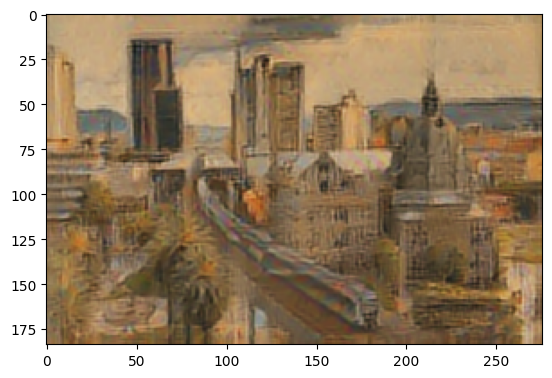

In [114]:
# Load content and style images (see example in the attached colab).
content_image = plt.imread(content_image_path)

# recommended style image of 256 pixels (this size was used when training the style transfer network).
# The content image can be any size.
style_image = plt.imread(style_image_path).astype(np.float32)[np.newaxis, ...] / 255.
style_image = tf.image.resize(style_image, (256, 256))

# Load image stylization module.
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

def fast_style_transfer(content_image, style_image,hub_module):
  # Convert to float32 numpy array, add batch dimension, and normalize to range [0, 1]. Example using numpy:
  content_image = content_image.astype(np.float32)[np.newaxis, ...] / 255.

  # Stylize image.
  outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
  stylized_image = outputs[0]
  return stylized_image[0]

new_img=fast_style_transfer(content_image, style_image,hub_module)
plt.imshow(new_img); plt.savefig("stylized_image.jpg")

# short video style transfer

In [112]:
from tqdm.notebook import tqdm

vidcap = cv2.VideoCapture('frankfurt.mp4')
assert vidcap.isOpened()

fps_in = vidcap.get(cv2.CAP_PROP_FPS); fps_out = 10
index_in, index_out = -1, -1

pbar = tqdm(total=int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT)))
frames=[]
while True:
    success = vidcap.grab()
    if not success: break
    index_in += 1

    out_due = int(index_in / fps_in * fps_out)
    if out_due > index_out:
        success, frame = vidcap.retrieve()
        if not success: break
        index_out += 1

        # do something with `frame`
        # converting BGR to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        styled_frame=fast_style_transfer(frame,style_image,hub_module)
        frames.append(styled_frame)
    pbar.update(1)

  0%|          | 0/390 [00:00<?, ?it/s]

In [115]:
# save to mp4
out = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps_out, (frames[0].shape[1], frames[0].shape[0]))
for img in frames:
    array=img.numpy()
    normalized_array = (array - np.min(array))/(np.max(array) - np.min(array)) # this set the range from 0 till 1
    img_array = (normalized_array * 255).astype(np.uint8) # set is to a range from 0 till 255
    img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
    out.write(img_array)
out.release()